In [1]:
#data parameters
data_path = 'KNYITHAC52.csv'
test_ratio = 0.1
windows = 6
pred_step = 12
avg_windows = 10
target_id = 9

#model parameters
lstm_dim = 128
fc_dim = 128

#training parameters
training_state = True
learning_rate=1e-3
dropout = 0.1
batch_size = 256
num_epoch = 1000

#visualization para
test_show_num = 1000

#path para
best_model_LSTM = 'LSTM.h5'

            Temperature_C  Dew_Point_C  Humidity_%  Speed_kmh  Gust_kmh  \
Date                                                                      
1/1/2021             0.00        -5.44          67        0.0      0.00   
1/1/2021             0.00        -5.67          66        0.0      0.00   
1/1/2021             0.00        -5.78          65        0.0      0.00   
1/1/2021             0.00        -5.89          64        0.0      0.00   
1/1/2021             0.00        -6.22          63        0.0      0.00   
...                   ...          ...         ...        ...       ...   
12/31/2021           3.89         3.67          98        0.0      0.00   
12/31/2021           4.44         4.17          98        0.0      0.00   
12/31/2021           5.06         4.72          98        0.0      0.16   
12/31/2021           5.72         5.33          97        0.0      0.00   
12/31/2021           6.33         5.94          97        0.0      0.00   

            Pressure_hPa

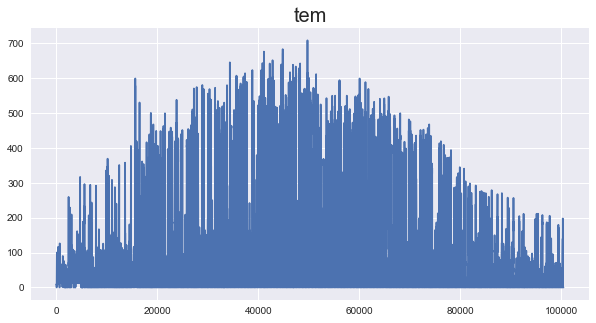



x_train.shape (90330, 6, 26)
x2_train.shape (90330, 10)
y_train.shape (90330, 12)
x_test.shape (10039, 6, 26)
x2_test.shape (10039, 10)
y_test.shape (10039, 12)


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
plt.style.use('seaborn')
#tensorflow==2.4.0 keras==2.4.3 python==3.7.10

#plot
def myPlot(array, name):
    plt.figure(figsize=(10,5))
    plt.plot(array)
    plt.title(name,fontsize='20') 
    plt.show()
    print('\n')

#minmaxscaler
def myScaler(data, target):
    mm_x= MinMaxScaler()
    mm_y= MinMaxScaler()
    data = mm_x.fit_transform(data)
    label = mm_y.fit_transform(np.reshape(target, (-1, 1)))  
    return  data, label, mm_y

def dataGenerator(data, label, test_ratio, windows, avg_windows,pred_step):
    data = np.array(data)
    cut = round(test_ratio* data.shape[0])
    lstm_input = []
    lstm_input2 = []
    lstm_output = []
    if avg_windows>windows:
        for i in range(len(data)-avg_windows-pred_step):
            lstm_input.append(data[i+(avg_windows-windows):i+avg_windows,:])
            lstm_input2.append(data[i:i+avg_windows,:])           
            lstm_output.append(data[i+avg_windows:i+avg_windows+pred_step:,target_id])
    else:
        for i in range(len(data)-windows-pred_step):
            lstm_input.append(data[i:i+windows,:])
            lstm_input2.append(data[i+(windows-avg_windows):i+windows,:])           
            lstm_output.append(data[i+windows:i+windows+pred_step,target_id])        
    lstm_input=np.array(lstm_input)
    lstm_input2=np.array(lstm_input2)
    lstm_input2 = lstm_input2.mean(axis=-1)
    lstm_output=np.array(lstm_output)  
    x_train,x2_train,y_train = lstm_input[:-cut,:,:],lstm_input2[:-cut,:],lstm_output[:-cut:]
    x_test,x2_test,y_test = lstm_input[-cut:,:,:],lstm_input2[-cut:,:],lstm_output[-cut:]
    print('x_train.shape',x_train.shape)
    print('x2_train.shape',x2_train.shape)
    print('y_train.shape',y_train.shape)
    print('x_test.shape',x_test.shape)
    print('x2_test.shape',x2_test.shape)
    print('y_test.shape',y_test.shape)
    return x_train, x2_train, x_test, y_train, x2_test, y_test

#read data
data = pd.read_csv(data_path, header=0, index_col=0)
data = data.iloc[:,1:]
data = pd.get_dummies(data)
print(data)
print(data.describe())
target = data.iloc[:,target_id].values

#plot y
myPlot(target, 'tem')

#scaler
data, label, mm_y = myScaler(data, target)

#generate data
x_train, x2_train, x_test, y_train, x2_test, y_test = dataGenerator(data,
                       label, test_ratio, windows, avg_windows,pred_step)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 26)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          79360       ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 128)          0           ['lstm[0][0]']                   
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                              

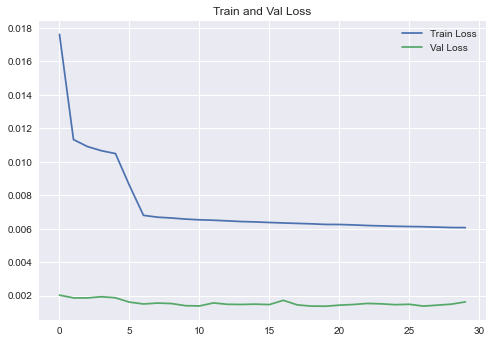

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input,LSTM,Dropout,Dense,Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

def lstm_model():
    inputs = Input(shape=x_train.shape[1:])
    inputs2 = Input(shape=x2_train.shape[1:])
    
    lstm = LSTM(units=lstm_dim, return_sequences=False)(inputs)
    lstm = Dropout(dropout)(lstm)
    dense = Dense(fc_dim, activation="relu", use_bias=True)(lstm)
    
    dense2 = Dense(fc_dim, activation="relu", use_bias=True)(inputs2)
    
    outputs = Dense(pred_step, activation="relu", use_bias=True)(Concatenate(axis=1)([dense, dense2]))
    
    model = Model(inputs=[inputs, inputs2], outputs=outputs)
    print(model.summary())
    model.compile(optimizer=RMSprop(learning_rate=1e-4), loss='mse',metrics=['accuracy'])
    return model

def myTrain(myModel, training_state, Path):
    es_patience = 10
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=es_patience)
    cp = keras.callbacks.ModelCheckpoint(filepath = Path, monitor='val_loss', save_best_only=True)
    if training_state==True:
        history = myModel.fit(x= [x_train, x2_train],
                            y= y_train,
                            batch_size=batch_size,
                            epochs=num_epoch,
                            verbose=1,
                            callbacks=[es, cp],
                            validation_split=0.1)
        myLossPlot(history)
    myModel.load_weights(Path) 
    return myModel

def myLossPlot(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(loss))
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Train and Val Loss')
    plt.show()

myModel = lstm_model()
myModel = myTrain(myModel, training_state, best_model_LSTM)

==============LSTM_LT Test Result===============


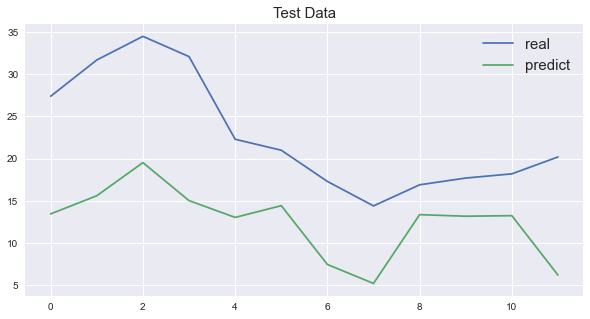

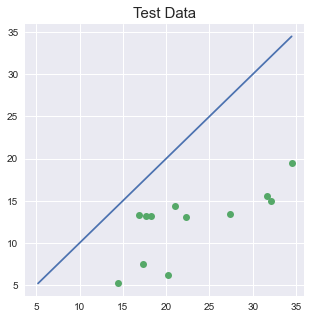

MAE     7.372885
RMSE    8.519252
MAPE         NaN
R^2          NaN
dtype: float64
==============LSTM_LT Test Result===============


In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt
        
def myInverseScaler(pred, mm_y):
    pred=np.reshape(pred, (-1,1))  
    pred= mm_y.inverse_transform(pred)
    pred=pred[:,0]
    return pred

def mape(y_true, y_pred):    
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred)/y_true))/n*100
    return mape

def myResultPlot(pred, real, trainToken):
    plt.figure(figsize=(10,5))
    plt.plot(real)
    plt.plot(pred)
    plt.legend(('real', 'predict'),fontsize='15')
    plt.title("%s Data"%(trainToken),fontsize='15')
    plt.show()
    print('\n')

    plot_begin,plot_end=min(min(pred),min(real)),max(max(pred),max(real))
    plot_x=np.linspace(plot_begin,plot_end,10)
    plt.figure(figsize=(5,5))
    plt.plot(plot_x,plot_x)
    plt.plot(real,pred,'o')
    plt.title("%s Data"%trainToken,fontsize='15')
    plt.show()

def myResult(pred_list, real_list, trainToken, modelToken, mm_y):
    print('==============%s %s Result==============='%(modelToken, trainToken))
    record = []
    count = 0
    for real, pred in zip(real_list, pred_list):
        count+=1
        real = mm_y.inverse_transform(np.reshape(real, (-1, 1)))
        pred = mm_y.inverse_transform(np.reshape(pred, (-1, 1)))
        if count==703:
            myResultPlot(pred, real, trainToken)
        record2 = []
        record2.append(mean_absolute_error(real, pred))
        record2.append(np.sqrt(mean_squared_error(real, pred)))
        record2.append(None)#mape(real, pred)
        record2.append(None)#r2_score(real, pred)
        record.append(record2)
    result = pd.DataFrame(record)  
    result.columns = ['MAE','RMSE','MAPE','R^2']
    print(result.mean())      
    print('==============%s %s Result==============='%(modelToken, trainToken))
    
y_pred = myModel.predict([x_test, x2_test])
myResult(pred_list = y_pred,
     real_list = y_test,
     trainToken='Test',
     modelToken='LSTM_LT',
    mm_y = mm_y
    )